# Modeling Joint Dependence in Financial Returns Using Copulas

In [1]:
# pip install pyCopula

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copulas.multivariate import GaussianMultivariate
from copulas.bivariate import Gumbel
# from copulas.bivariate.base import  Bivariate, CopulaTypes
from scipy.stats import norm

In [3]:
# Fetch historical stock data (adjusted close prices) for Apple and Google
stocks = ['AAPL', 'GOOGL']
data = yf.download(stocks, start='2019-01-01', end='2024-01-01')['Adj Close']

# Calculate log returns (log(P_t / P_(t-1)))
log_returns = np.log(data / data.shift(1)).dropna()

[*********************100%***********************]  2 of 2 completed


In [4]:
# Calculate mean and standard deviation for Apple log returns
mean_aapl = log_returns['AAPL'].mean()
std_aapl = log_returns['AAPL'].std()

# Generate x-values for the normal distribution (range from min to max of AAPL log returns)
x_aapl = np.linspace(log_returns['AAPL'].min(), log_returns['AAPL'].max(), 1000)

# Calculate the PDF of the normal distribution using the mean and standard deviation
pdf_aapl = norm.pdf(x_aapl, mean_aapl, std_aapl)

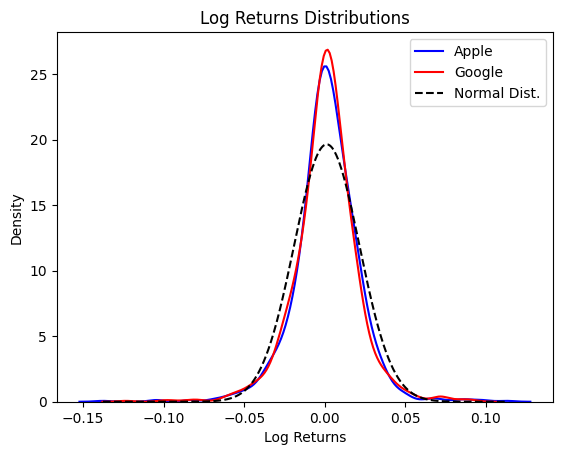

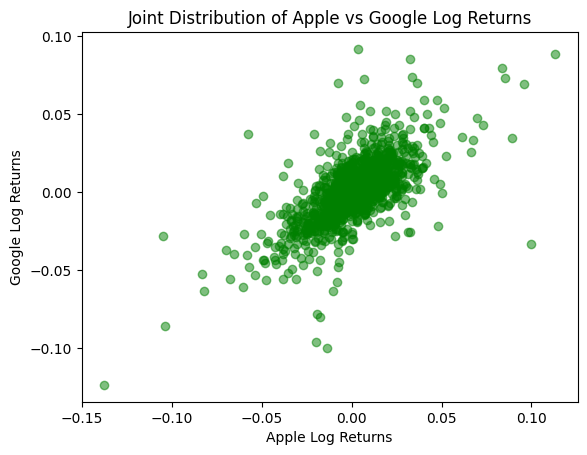

In [5]:
# Plot individual asset distributions (log returns)
sns.kdeplot(log_returns['AAPL'], label='Apple', color='blue')
sns.kdeplot(log_returns['GOOGL'], label='Google', color='red')
plt.plot(x_aapl, pdf_aapl, label='Normal Dist.', color='black', linestyle='--')# Plot normal distributions on top
plt.legend()
plt.title('Log Returns Distributions')
plt.xlabel('Log Returns')
plt.show()

# Visualize the joint distribution of Apple and Google log returns (scatter plot)
plt.scatter(log_returns['AAPL'], log_returns['GOOGL'], alpha=0.5, color='green')
plt.title('Joint Distribution of Apple vs Google Log Returns')
plt.xlabel('Apple Log Returns')
plt.ylabel('Google Log Returns')
plt.show()

In [6]:
import scipy.stats as stats

mean1 = log_returns['AAPL'].mean()
sd1 = log_returns['AAPL'].std()
skew1=stats.skew(log_returns['AAPL'])
kurt1 = stats.kurtosis(log_returns['AAPL'])
print(mean1,sd1,skew1,kurt1)

mean2 = log_returns['GOOGL'].mean()
sd2 = log_returns['GOOGL'].std()
skew2=stats.skew(log_returns['GOOGL'])
kurt2 = stats.kurtosis(log_returns['GOOGL'])
print(mean2,sd2,skew2,kurt2)

0.0012931398086245978 0.020315340130878348 -0.26677411008154317 5.4164573015224295
0.0007749921834427838 0.020056623929754075 -0.24472545792598216 4.0894749981221725


In [7]:
# uniform_data = np.column_stack([
#     np.argsort(np.argsort(log_returns['AAPL'])) / len(log_returns),
#     np.argsort(np.argsort(log_returns['GOOGL'])) / len(log_returns)
# ])

uniform_aapl = norm.cdf(log_returns['AAPL'], loc=mean1, scale=sd1)
uniform_google = norm.cdf(log_returns['GOOGL'], loc=mean2, scale=sd2)
# For a 2D Gumbel copula (AAPL and GOOGL), you need both assets' uniform data
uniform_data = np.column_stack([uniform_aapl, uniform_google])

In [8]:
# Fit Gaussian Copula
gaussian_copula = GaussianMultivariate()
gaussian_copula.fit(uniform_data)

# Fit Gumbel-Hougaard Copula
gumbel_copula = Gumbel()
gumbel_copula.fit(uniform_data) 
# simulated_gumbel = gumbel_copula.sample(len(log_returns))

# gumbel_copula = ArchimedeanCopula(family="gumbel", dim=2)
# gumbel_copula.fit(uniform_data, method="cmle")

# Simulate data using the fitted copulas
# simulated_gaussian = gaussian_copula.sample(len(log_returns))
# simulated_gumbel = gumbel_copula.sample(len(log_returns))

C:\Users\wongl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\copulas\bivariate\base.py:163: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn('Data does not appear to be uniform.', category=RuntimeWarning)


C:\Users\wongl\AppData\Local\Temp\ipykernel_15880\2861152761.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


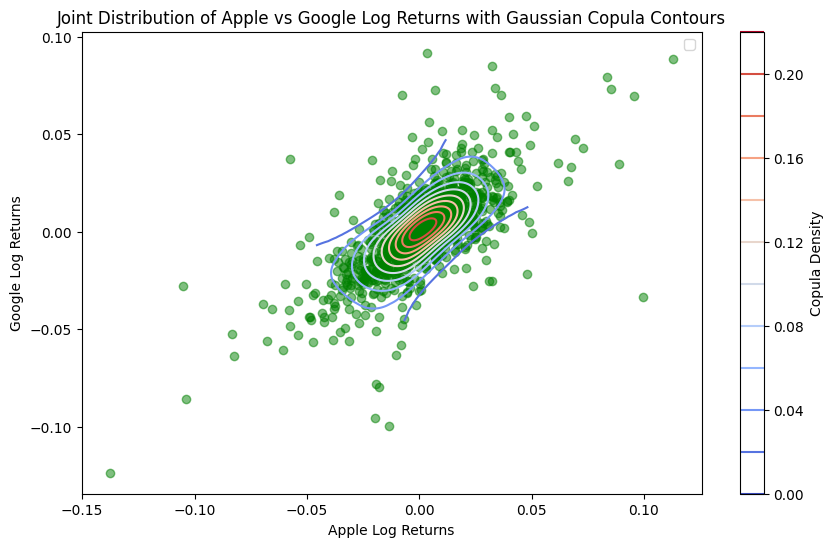

In [9]:
# Generate a grid in the uniform space
u = np.linspace(0.01, 0.99, 100)  # Avoid extremes (0, 1) to prevent numerical issues
v = np.linspace(0.01, 0.99, 100)
U, V = np.meshgrid(u, v)
grid_uniform = np.column_stack([U.ravel(), V.ravel()])

# Evaluate the copula density at the grid points
copula_density = gaussian_copula.probability_density(grid_uniform)
copula_density = copula_density.reshape(U.shape)

# Transform grid points back to the log return scale
X = norm.ppf(U, loc=log_returns['AAPL'].mean(), scale=log_returns['AAPL'].std())
Y = norm.ppf(V, loc=log_returns['GOOGL'].mean(), scale=log_returns['GOOGL'].std())

# Plot joint scatter of log returns (Apple vs Google)
plt.figure(figsize=(10, 6))
plt.scatter(log_returns['AAPL'], log_returns['GOOGL'], alpha=0.5, color='green')

# Overlay the copula contours
contour = plt.contour(X, Y, copula_density, levels=10, cmap='coolwarm')
plt.colorbar(contour, label='Copula Density')

# Add labels and legend
plt.title('Joint Distribution of Apple vs Google Log Returns with Gaussian Copula Contours')
plt.xlabel('Apple Log Returns')
plt.ylabel('Google Log Returns')
plt.legend()
plt.show()

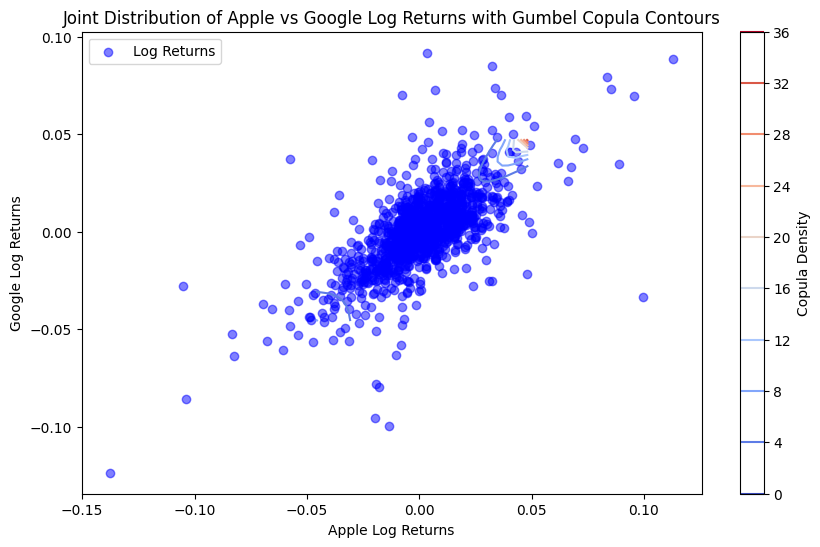

In [10]:
# Step 2: Generate a grid in the uniform space
u = np.linspace(0.01, 0.99, 100)  # Avoid extremes to prevent numerical issues
v = np.linspace(0.01, 0.99, 100)
U, V = np.meshgrid(u, v)
grid_uniform = np.column_stack([U.ravel(), V.ravel()]) 

# # Step 3: Evaluate the Gumbel copula density at the grid points
# copula_density = np.array([gumbel_copula.pdf(pair) for pair in grid_uniform])  # Evaluate row by row
copula_density = gumbel_copula.probability_density(grid_uniform)
copula_density = copula_density.reshape(U.shape)  # Reshape to match grid

# Step 4: Transform grid points back to the log return scale
X = norm.ppf(U, loc=log_returns['AAPL'].mean(), scale=log_returns['AAPL'].std())
Y = norm.ppf(V, loc=log_returns['GOOGL'].mean(), scale=log_returns['GOOGL'].std())

# Step 5: Plot the log returns scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(log_returns['AAPL'], log_returns['GOOGL'], alpha=0.5, color='blue', label='Log Returns')

# Overlay the Gumbel copula contours
contour = plt.contour(X, Y, copula_density, levels=10, cmap='coolwarm')
plt.colorbar(contour, label='Copula Density')

# Add labels and legend
plt.title('Joint Distribution of Apple vs Google Log Returns with Gumbel Copula Contours')
plt.xlabel('Apple Log Returns')
plt.ylabel('Google Log Returns')
plt.legend()
plt.show()


C:\Users\wongl\AppData\Local\Temp\ipykernel_15880\782936344.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


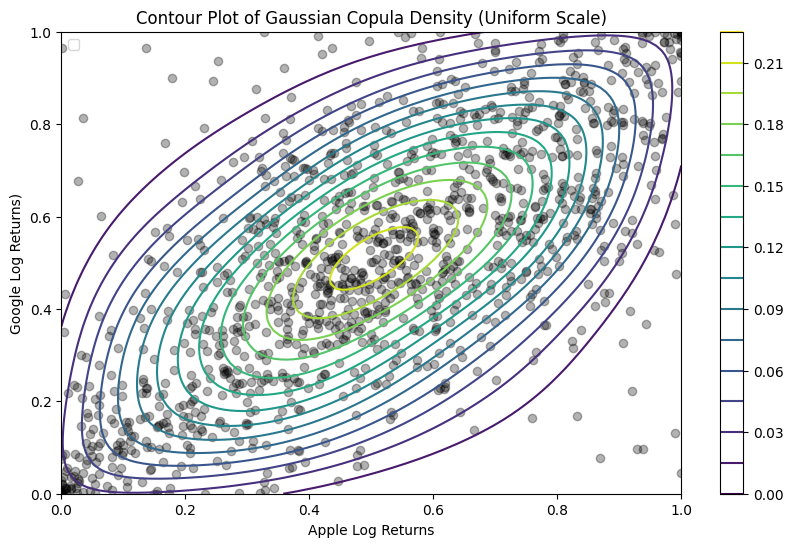

In [11]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
grid_uniform = np.column_stack([X.ravel(), Y.ravel()])

# Step 4: Calculate the copula's density on this uniform grid
copula_density = gaussian_copula.pdf(grid_uniform).reshape(X.shape)

# Step 5: Plot the contour of the copula density on the uniform scale
plt.figure(figsize=(10, 6))

# Create contour plot
cp = plt.contour(X, Y, copula_density, 20)

# Add labels and title
plt.title('Contour Plot of Gaussian Copula Density (Uniform Scale)')
plt.xlabel('Apple Log Returns')
plt.ylabel('Google Log Returns)')
plt.colorbar(cp)

# Overlay original log returns as scatter plot
plt.scatter(uniform_data[:, 0], uniform_data[:, 1], alpha=0.3, color='black')

plt.legend()
plt.show()

C:\Users\wongl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\copulas\bivariate\gumbel.py:52: RuntimeWarning: divide by zero encountered in power
  a = np.power(U * V, -1)
C:\Users\wongl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\copulas\bivariate\gumbel.py:53: RuntimeWarning: divide by zero encountered in log
  tmp = np.power(-np.log(U), self.theta) + np.power(-np.log(V), self.theta)
C:\Users\wongl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\copulas\bivariate\gumbel.py:54: RuntimeWarning: divide by zero encountered in power
  b = np.power(tmp, -2 + 2.0 / self.theta)
C:\Users\wongl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\copulas\bivariate\gumbel.py:55: RuntimeWarning: d

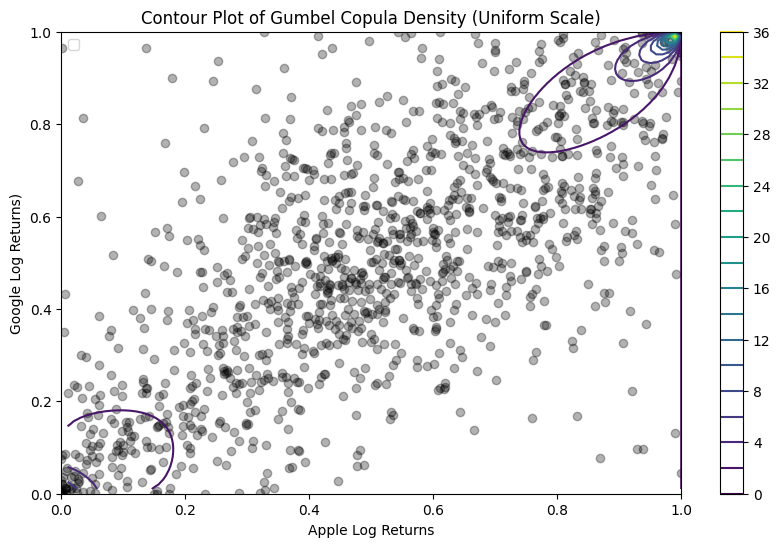

In [12]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
grid_uniform = np.column_stack([X.ravel(), Y.ravel()])

# Step 4: Calculate the copula's density on this uniform grid
copula_density = gumbel_copula.pdf(grid_uniform).reshape(X.shape)
# copula_density = np.array([gumbel_copula.pdf(pair) for pair in grid_uniform])  # Evaluate row by row

# Step 5: Plot the contour of the copula density on the uniform scale
plt.figure(figsize=(10, 6))

# Create contour plot
cp = plt.contour(X, Y, copula_density, 20)

# Add labels and title
plt.title('Contour Plot of Gumbel Copula Density (Uniform Scale)')
plt.xlabel('Apple Log Returns')
plt.ylabel('Google Log Returns)')
plt.colorbar(cp)


# Overlay original log returns as scatter plot
plt.scatter(uniform_data[:, 0], uniform_data[:, 1], alpha=0.3, color='black')

plt.legend()
plt.show()

In [13]:
# # Visualize the simulated data using scatter plots
# plt.figure(figsize=(12, 6))

# # Gaussian Copula Simulation
# plt.subplot(1, 2, 1)
# plt.scatter(simulated_gaussian[0], simulated_gaussian[1], alpha=0.5, color='green')
# plt.title('Simulated Data using Gaussian Copula')
# plt.xlabel('Simulated Apple Log Returns')
# plt.ylabel('Simulated Google Log Returns')

In [14]:
gaussian_copula.correlation

,0,1
0,1.000000,0.677696
1,0.677696,1.000000


In [15]:
gumbel_copula.theta

1.9596924646677387

In [16]:
log_prob_density = gaussian_copula.log_probability_density(uniform_data) 
log_likelihood = np.sum(log_prob_density)

# Assuming you know the number of parameters (e.g., k = 1 for 2D Gaussian copula)
k = 1

# Calculate AIC
AIC = 2 * k - 2 * log_likelihood
print("AIC for the Gaussian Copula:", AIC)
log_likelihood

AIC for the Gaussian Copula: 6087.419884998065


-3042.7099424990324

In [17]:
log_prob_density =gumbel_copula.log_probability_density(uniform_data)
log_likelihood = np.sum(log_prob_density)

# Assuming you know the number of parameters (e.g., k = 1 for 2D Gaussian copula)
k = 1

# Calculate AIC
AIC = 2 * k - (2 * log_likelihood)
print("AIC for the Gundel Copula:", AIC)
log_likelihood

AIC for the Gundel Copula: -704.9267676102511


353.46338380512555

In [18]:
gaussian_samples=gaussian_copula.sample(len(log_returns))
# synthetic_gaussian_aapl = norm.ppf(gaussian_samples[0])
# synthetic_gaussian_googl = norm.ppf(gaussian_samples[ 1])
synthetic_gaussian_aapl=gaussian_samples[0]
synthetic_gaussian_googl=gaussian_samples[1]
gumbel_samples=gumbel_copula.sample(len(log_returns))
# synthetic_gumbel_aapl = norm.ppf(gumbel_samples[0])
# synthetic_gumbel_googl = norm.ppf(gumbel_samples[1])
synthetic_gumbel_aapl = gumbel_samples[:,0]
synthetic_gumbel_googl = gumbel_samples[:,1]

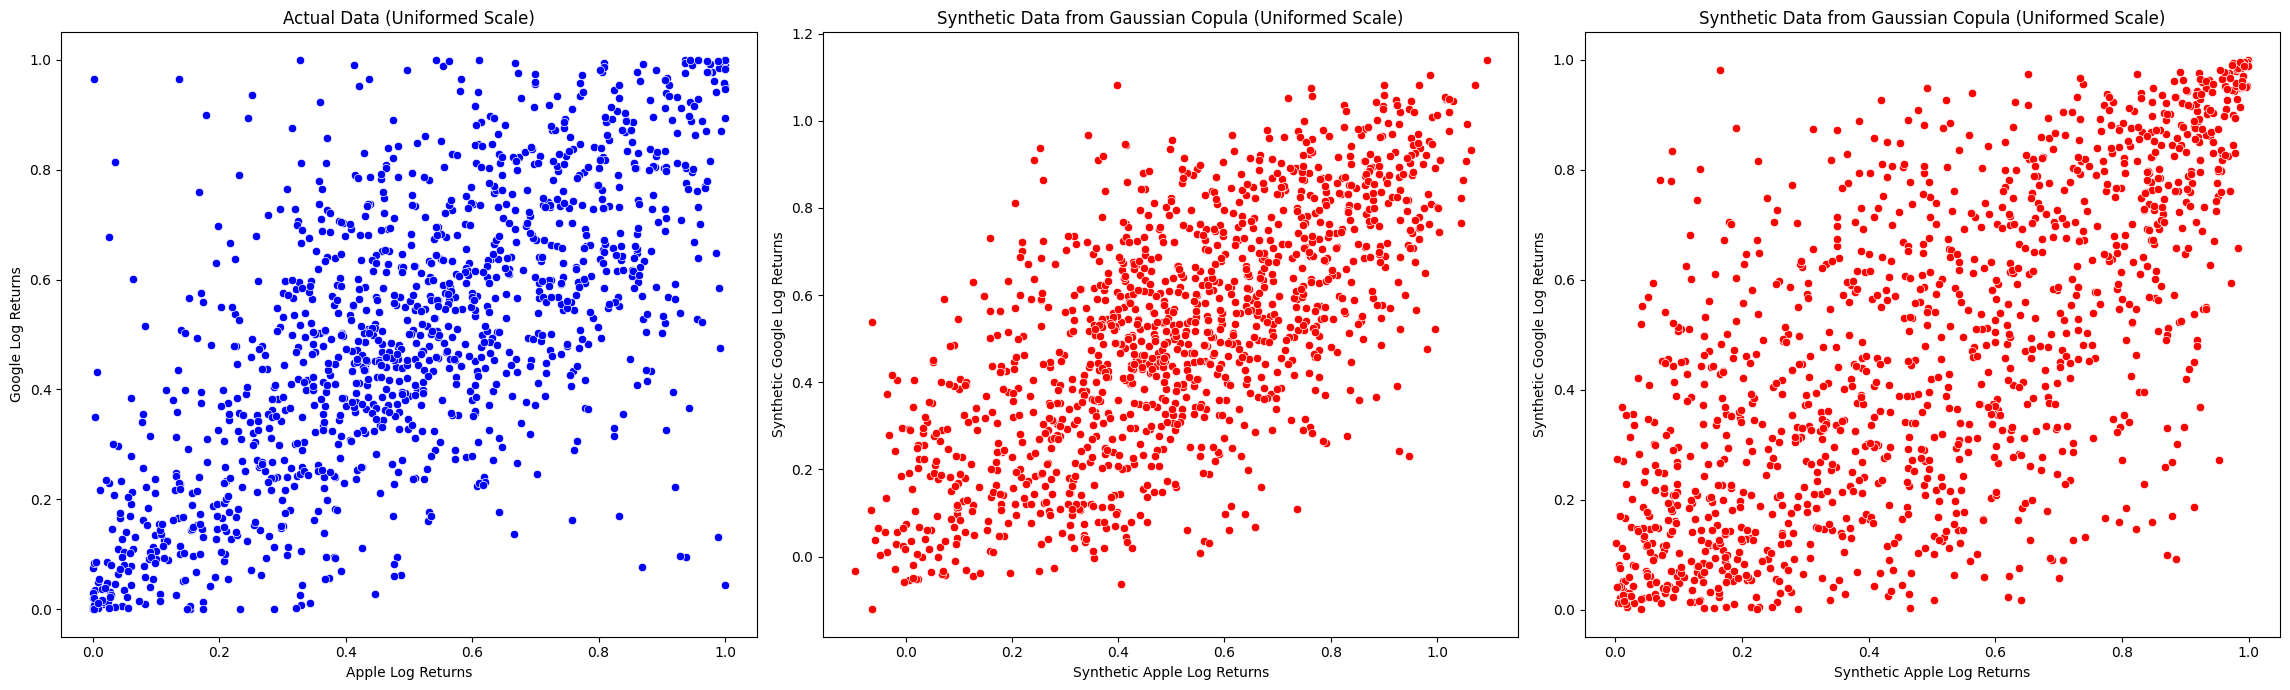

In [23]:
plt.figure(figsize=(23, 7))

# Plot Original Log Returns
plt.subplot(1, 3, 1)
sns.scatterplot(x=uniform_aapl, y=uniform_google, color='blue')
plt.title('Actual Data (Uniformed Scale)')
plt.xlabel('Apple Log Returns')
plt.ylabel('Google Log Returns')

# Plot Synthetic Data from Gaussian Copula
plt.subplot(1, 3, 2)
sns.scatterplot(x=synthetic_gaussian_aapl, y=synthetic_gaussian_googl, color='red')
plt.title('Synthetic Data from Gaussian Copula (Uniformed Scale)')
plt.xlabel('Synthetic Apple Log Returns')
plt.ylabel('Synthetic Google Log Returns')

# Plot Synthetic Data from Gumbel Copula
plt.subplot(1, 3, 3)
sns.scatterplot(x=synthetic_gumbel_aapl, y=synthetic_gumbel_googl, color='red')
plt.title('Synthetic Data from Gaussian Copula (Uniformed Scale)')
plt.xlabel('Synthetic Apple Log Returns')
plt.ylabel('Synthetic Google Log Returns')

plt.tight_layout()
plt.show()

In [21]:
rho = gaussian_copula.correlation  # get correlation (rho)

# Compute upper tail dependence (λ_U)
lambda_U = 2 * norm.cdf(-1 / np.sqrt(1 - rho**2)) - 1

# Compute lower tail dependence (λ_L)
lambda_L = 2 * norm.cdf(1 / np.sqrt(1 - rho**2)) - 1

print(f"Gaussian Copula Correlation: {rho}") 
print(f"Gaussian Copula Upper Tail Dependence: {lambda_U}") #-0.826
print(f"Gaussian Copula Lower Tail Dependence: {lambda_L}")

Gaussian Copula Correlation:           0         1
0  1.000000  0.677696
1  0.677696  1.000000
Gaussian Copula Upper Tail Dependence: [[-1.         -0.82614184]
 [-0.82614184 -1.        ]]
Gaussian Copula Lower Tail Dependence: [[1.         0.82614184]
 [0.82614184 1.        ]]


In [22]:
theta = gumbel_copula.theta  # Gumbel copula parameter (theta)

# Compute Gumbel copula correlation
correlation_gumbel = (theta - 1) / theta  # Correlation formula for Gumbel copula

# Compute upper tail dependence for Gumbel copula
lambda_U_gumbel = 2 - 2 / theta

# Lower tail dependence is always 0 for Gumbel
lambda_L_gumbel = 0

print(f"Gumbel Copula Parameter (θ): {theta}")
print(f"Gumbel Copula Correlation: {correlation_gumbel}")
print(f"Gumbel Copula Upper Tail Dependence: {lambda_U_gumbel}")
print(f"Gumbel Copula Lower Tail Dependence: {lambda_L_gumbel}")

Gumbel Copula Parameter (θ): 1.9596924646677387
Gumbel Copula Correlation: 0.4897158518341562
Gumbel Copula Upper Tail Dependence: 0.9794317036683124
Gumbel Copula Lower Tail Dependence: 0
